# [DRAFT] Applying WOfS to Sentinel 2 ARD <img align="right" src="../Applying WOfS to S2/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* <b>Products Used:</b> [Sentinel 2A ARD](https://explorer.sandbox.dea.ga.gov.au/products/ga_s2am_ard_3) and [Sentinel 2B ARD](https://explorer.sandbox.dea.ga.gov.au/products/ga_s2bm_ard_3)

## Background
This notebook demonstrates how WOfS can be applied to Sentinel 2 ARD imagery. In this example, the WOfS codebase from [DEA Water Observations](DEA_Water_Observations.ipynb) has been used without change. This algorithm was designed for Landsat 8 imagery, hence there are some artefacts in the Sentinel 2 outputs and adjustments will need to be made to improve data quality. This is addressed in the following notebook <span style="color:red; font-size:18px"> LINK TO NEXT NOTEBOOK </span>.



## Description
If we have a vector file containing multiple polygons representing S2 ARD granules, we can use the python package [geopandas](https://geopandas.org/) to open it as a `GeoDataFrame`. 
We can then iterate through each geometry and extract satellite data corresponding with the extent of each geometry. 
Further anlaysis can then be conducted on each resulting `xarray.Dataset`.

We can retrieve data for each polygon, apply WOfS and plot the data.

1. First we open the vector file as a `geopandas.GeoDataFrame`
2. Iterate through each polygon in the `GeoDataFrame`, and extract satellite data from DEA
3. Mask some clouds as an example
4. Plot masked output for the polygon extent. 

***


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Please note the use of `datacube.utils` package `geometry`: 
this is important for saving the coordinate reference system of the incoming shapefile in a format that the Digital Earth Australia query can understand.

In [11]:
%matplotlib inline

import datacube
import rasterio.crs
from datetime import datetime, timedelta
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.geometry import Geometry, CRS
from odc.ui import with_ui_cbk
# from wofs.wofls import woffles_ard

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import rgb, plot_wo
from dea_tools.temporal import time_buffer
from dea_tools.spatial import xr_rasterize
from dea_tools.dask import create_local_dask_cluster

# local copies
sys.path.insert(1, "../Applying WOfS to S2/wofs165/")
from wofs.wofls import woffles_ard

### Connect to the datacube
Connect to the datacube database to enable loading Digital Earth Australia data.

In [12]:
dc = datacube.Datacube(app='Cloud_Masking_polygons')
client = create_local_dask_cluster(return_client=True)

/env/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35415 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/yukie.nip@ga.gov.au/proxy/35415/status,
Dashboard: /user/yukie.nip@ga.gov.au/proxy/35415/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36297,Workers: 1
Dashboard: /user/yukie.nip@ga.gov.au/proxy/35415/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:35079,Total threads: 2
Dashboard: /user/yukie.nip@ga.gov.au/proxy/42197/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:34233,


# Sample Inputs
This notebook demonstrates how the WOfS classifier can use S2 granules as inputs. The sample inputs `Aus_Sample_Granules.geojson` is a set of 27 granules randomly spaced across Australia. A smaller area `Sample_Site.geojson` can be used as a faster alternative. This area has been selected to provide an example of the granule boundary artefact. 

## Analysis parameters
This notebook is about applying the DEA Landsat 8 Water Observations classifier to Sentinel 2 ARD. There are some parameters that are fixed (eg. anything associated with physical satellite properties), and some testing parameters that are dynamic (eg. algorithm parameters).
### Fixed Parameters 
* `products` : A list of product names to load from the datacube e.g. `["ga_s2am_ard_3", "ga_s2bm_ard_3"]`
* `measurements` : A list of band names to load from the satellite product e.g. `["nbart_coastal_aerosol", "nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3", "oa_fmask"]`
* `resolution` : The spatial resolution of the loaded satellite data e.g. for Sentinel 2, this is `(-10, 10)`
* `output_crs` : The coordinate reference system/map projection to load data into, e.g. `'EPSG:3577'` to load data in the Albers Equal Area projection
* `align` : How to align the x, y coordinates respect to each pixel.<span style="color:red;"> CHECK  Sentinel 2 Collection 3 should be <b> centre aligned </b>`align = (5, 5)`</span> if data is loaded in its native UTM zone projection, e.g. `'EPSG:32756'` 

### Dynamic Parameters
* `time_of_interest` : Enter a time, in units YYYY-MM-DD, around which to load satellite data e.g. `'2019-01-01'`
* `time_buff` : A buffer of a given duration (e.g. days) around the time_of_interest parameter, e.g. `'30 days'`. For testing, we already know where and when to look, so the buffer can be reduced to 1 day to speed up processing time.
* `vector_file` : A path to a vector file (ESRI Shapefile or GeoJSON). Vector files are used to group polygons by days for easier loading.
* `attribute_col` : A column in the vector file used to label the output `xarray` datasets containing satellite images. Each row of this column should have a unique identifier


In [13]:
# Fixed parameters
products = ["ga_s2am_ard_3", "ga_s2bm_ard_3"]
# don't need red edge, not concerned about vegetation.
measurements = ["nbart_coastal_aerosol", "nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1", "nbart_nir_2", "nbart_swir_2", "nbart_swir_3", "oa_fmask"]
resolution = (-10, 10)
output_crs = "EPSG:3577"
align = (5, 5) # check this
maturity = "final" 


In [15]:
# Dynamic Parameters - don't bother with time buffer if you know which date the images were captured.
time_of_interest = '2023-04-03'
time_buff = '3 days'

vector_file = '../Applying WOfS to S2/Sample_Site.geojson'
attribute_col = 'ID'

### Look at the structure of the vector file
Import the file and take a look at how the file is structured so we understand what we are iterating through. 

In [16]:
gdf = gpd.read_file(vector_file)
gdf.head()

,ID,geometry
0,3,"POLYGON ((118.73674 -27.75929, 118.73674 -28.2..."


We can then plot the `geopandas.GeoDataFrame` on an interactive map to make sure it covers the area of interest we are concerned with:

In [17]:
gdf.explore(column=[2])

### Create a datacube query object
We then create a dictionary that will contain the parameters that will be used to load data from the DEA data cube:

> **Note:** We do not include the usual `x` and `y` spatial query parameters here, as these will be taken directly from each of our vector polygon objects.

In [18]:
# Find matching datasets    
def loadquery(products, time_of_interest, time_buff, measurements, resolution, align, gdf):
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
         
    dss = dc.find_datasets(product=products, time=time_of_interest, geopolygon=geom)
    # Identify native CRS from datasets; fall back on "EPSG:3577"    # if no data is found to prevent an error    
    native_crs = dss[0].crs if len(dss) > 0 else "EPSG:3577"

    query = {'time': time_buffer(time_of_interest, buffer=time_buff),
             'measurements': measurements,
             'resolution': resolution,
             'output_crs': native_crs,
             'align': align,
             'group_by': 'solar_day',
             'dask_chunks':{}
             }

    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})                                            
                                              
    return query                                         


## Loading Satellite Data

Here we will iterate through each row of the `geopandas.GeoDataFrame` and load satellite data.  The results will be appended to a dictionary object which we can later index to analyse each dataset.


In [19]:
# Dictionary to save results 
results = {}

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf.iterrows():
    
    print(f'Feature: {index + 1}/{len(gdf)}')
   
    query = loadquery(products, time_of_interest, time_buff, measurements, resolution, align, gdf)
    
    # Load Sentinel 2
    ds = dc.load(product=("ga_s2am_ard_3","ga_s2bm_ard_3"),
            progress_cbk=with_ui_cbk(),
            dataset_maturity="final",
            **query)
    ds['fmask'] = ds['oa_fmask']

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    ds = ds.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({str(row[attribute_col]): ds})


Feature: 1/1


---
## Further analysis

Our `results` dictionary will contain `xarray` objects labelled by the unique `attribute column` values we specified in the `Analysis parameters` section:

In [20]:
results

{'3': <xarray.Dataset>
 Dimensions:                (time: 1, y: 5588, x: 7409)
 Coordinates:
   * time                   (time) datetime64[ns] 2023-04-03T02:15:17.321399
   * y                      (y) float64 6.928e+06 6.928e+06 ... 6.872e+06
   * x                      (x) float64 6.704e+05 6.704e+05 ... 7.445e+05
     spatial_ref            int32 32750
 Data variables:
     nbart_coastal_aerosol  (time, y, x) float32 dask.array<chunksize=(1, 5588, 7409), meta=np.ndarray>
     nbart_blue             (time, y, x) float32 dask.array<chunksize=(1, 5588, 7409), meta=np.ndarray>
     nbart_green            (time, y, x) float32 dask.array<chunksize=(1, 5588, 7409), meta=np.ndarray>
     nbart_red              (time, y, x) float32 dask.array<chunksize=(1, 5588, 7409), meta=np.ndarray>
     nbart_nir_1            (time, y, x) float32 dask.array<chunksize=(1, 5588, 7409), meta=np.ndarray>
     nbart_nir_2            (time, y, x) float32 dask.array<chunksize=(1, 5588, 7409), meta=np.ndarray>
 

In [21]:
ds.isel(time=0)

<xarray.Dataset>
Dimensions:                (y: 5588, x: 7409)
Coordinates:
    time                   datetime64[ns] 2023-04-03T02:15:17.321399
  * y                      (y) float64 6.928e+06 6.928e+06 ... 6.872e+06
  * x                      (x) float64 6.704e+05 6.704e+05 ... 7.445e+05
    spatial_ref            int32 32750
Data variables:
    nbart_coastal_aerosol  (y, x) float32 dask.array<chunksize=(5588, 7409), meta=np.ndarray>
    nbart_blue             (y, x) float32 dask.array<chunksize=(5588, 7409), meta=np.ndarray>
    nbart_green            (y, x) float32 dask.array<chunksize=(5588, 7409), meta=np.ndarray>
    nbart_red              (y, x) float32 dask.array<chunksize=(5588, 7409), meta=np.ndarray>
    nbart_nir_1            (y, x) float32 dask.array<chunksize=(5588, 7409), meta=np.ndarray>
    nbart_nir_2            (y, x) float32 dask.array<chunksize=(5588, 7409), meta=np.ndarray>
    nbart_swir_2           (y, x) float32 dask.array<chunksize=(5588, 7409), meta=np.ndarray>
    nbart_swir_3           (y, x) float32 dask.array<chunksize=(5588, 7409), meta=np.ndarray>
    oa_fmask               (y, x) float32 dask.array<chunksize=(5588, 7409), meta=np.ndarray>
    fmask                  (y, x) float32 dask.array<chunksize=(5588, 7409), meta=np.ndarray>
Attributes:
    crs:           epsg:32750
    grid_mapping:  spatial_ref

Enter the polygon ID number/code to plot the RGB and masked images for the corresponding granule. Granules have ID structures like 50HMH.

In [22]:
key = '3'

### Plot an RGB image
We can now use the `dea_plotting.rgb` function to plot our loaded data as a three-band RGB plot:

/env/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


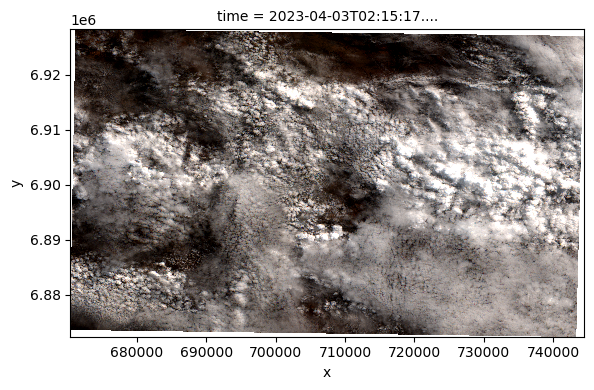

In [23]:
rgb(results[key], col='time', size=4)

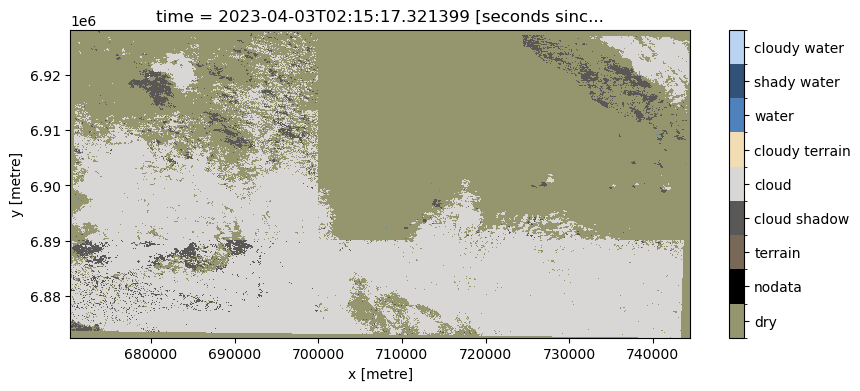

In [24]:
wofl = woffles_ard(ds.isel(time=0), dsm=None)
wofl

# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(gdf.iloc[[index]], wofl)

# Mask dataset to set pixels outside the polygon to `NaN`
gawofl = wofl.where(mask)

# Append results to a dictionary using the attribute
# column as a key
results.update({str(row[attribute_col]): wofl})

plot_wo(wofl, figsize=(10,4))


## Pitfalls and Further Opportunities
WOfS was originally designed for Landsat 8, which has thermal bands that are good for separating clouds from other surfaces. Sentinel 2 however, does not have any bands in this region and may therefore produce different results. The original algorithm also took entire scenes as inputs, however here we process the data on a granule by granule basis. `Sample Site` shows an example of the granule boundary being visible as a result of this method.

The WOfS algorithm assumes an Fmask layer already exists, and is dependent on this layer. However, there are parameters within the Fmask package that can be adjusted to better suit Sentinel 2 specifications and produce outputs of higher quality. This adaptation is currently being investigated. <span style="color:red;">insert link to next notebook when done </span>

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2023

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)